#  1. Анализ данных, 2. Фильтрация, 3. Преобразование переменных, 
# 4. Классификация моделей по типу кузова 

## Импорт необходимых библиотек

In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import dabl
warnings.simplefilter("ignore")
from pylab import rcParams

rcParams["figure.figsize"] = 10, 5

In [359]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [360]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection GridSearchCV

In [361]:
df = pd.read_csv('auto.csv', encoding='UTF-8')

In [362]:
df.head()

,brand,model,complect,type_car,seats,doors,Двигатель,Мощность,Крутящий момент двигателя,Коробка передач,...,Разгон до сотни,Максимальная скорость,Расход топлива (л/100 км)\nгород / трасса / смешанный,Дорожный просвет,Габариты (длина × ширина × высота),Колёсная база,Объём багажника,Объём багажника максимальный,Объём топливного бака,Масса автомобиля
0,Audi,A3 Sedan,1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),...,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
1,Audi,A3 Sedan,sport 1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),...,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
2,Audi,A3 Sedan,2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.8 секунды,250 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг
3,Audi,A3 Sedan,2.0 TFSI 7AMT quattro,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.2 секунды,242 км/ч,7.2 / 4.8 / 5.7,165 мм,4458 × 1796 × 1416,2637 мм,390 л,845 л,55 л,1465 кг
4,Audi,A3 Sedan,sport 2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.8 секунды,242 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг


In [363]:
df.shape

(1703, 21)

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1703 entries, 0 to 1702
Data columns (total 21 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   brand                                                 1703 non-null   object
 1   model                                                 1703 non-null   object
 2   complect                                              1703 non-null   object
 3   type_car                                              1703 non-null   object
 4   seats                                                 1703 non-null   int64 
 5   doors                                                 1703 non-null   int64 
 6   Двигатель                                             1703 non-null   object
 7   Мощность                                              1703 non-null   object
 8   Крутящий момент двигателя                             1703 non-null 

Видно, что большинство признаков представлены в неудобном для визуализации и анализа виде.

## Небольшой препроцессинг данных для визуализации и анализа
### Преобразуем некоторые признаки в понятный для анализа вид 
<u>object -> int/float </u>

In [365]:
labels_to_change = ['Мощность', 'Крутящий момент двигателя', 'Максимальная скорость', 'Дорожный просвет', 'Колёсная база', 'Объём багажника', 'Объём багажника максимальный', 'Объём топливного бака', 'Масса автомобиля']

In [366]:
# Уберем все размерности(л.с., Н*м, км/ч и т.д.)
for i in labels_to_change:
    df[i] = df[i].apply(lambda x: re.sub('\D', '', str(x)))
    df[i] = df[i].astype(str).astype(int)

In [367]:
df['Разгон до сотни'] = df['Разгон до сотни'].astype(str).replace('секунды','', regex=True)
df['Разгон до сотни'] = df['Разгон до сотни'].astype(str).replace('нет данных', None, regex=True).astype(float)

In [368]:
df['Разгон до сотни'].isnull().sum()

0

In [369]:
# Выделим в отдельные столбцы расходы по городу, трассе и смешанный
df['Расход топлива (л/100 км)\nгород / трасса / смешанный'] = df['Расход топлива (л/100 км)\nгород / трасса / смешанный'].str.split(' / ')

In [370]:
df['Расход_город'] = df["Расход топлива (л/100 км)\nгород / трасса / смешанный"].str[0].astype(float)
df['Расход_трасса'] = df['Расход топлива (л/100 км)\nгород / трасса / смешанный'].str[1].astype(float)
df['Расход_смешанный'] = df['Расход топлива (л/100 км)\nгород / трасса / смешанный'].str[2].astype(float)
df = df.drop(['Расход топлива (л/100 км)\nгород / трасса / смешанный'], axis=1)

In [371]:
# Проделаем тоже самое и с габаритами
df['Габариты (длина × ширина × высота)'] = df['Габариты (длина × ширина × высота)'].str.split(' × ')

In [372]:
df['длина'] = df['Габариты (длина × ширина × высота)'].str[0].astype(int)
df['ширина'] = df['Габариты (длина × ширина × высота)'].str[1].astype(int)
df['высота'] = df['Габариты (длина × ширина × высота)'].str[2].astype(int)
df.drop(['Габариты (длина × ширина × высота)'], axis=1, inplace=True)

In [373]:
# Выделим тип двигателя и объем из общего признака
df['тип_двигателя'] = df['Двигатель'].apply(lambda x: re.sub("\d+", "", x))
df['тип_двигателя'] = df['тип_двигателя'].astype(str).replace('(см³)', '', regex=True)
df['тип_двигателя'] = df['тип_двигателя'].apply(lambda x: re.sub('\W+','', x))

In [374]:
df['объем_двигателя'] = df['Двигатель'].apply(lambda x: re.sub('\D', '', x)).astype(int)
df.drop(['Двигатель'], axis=1, inplace=True)

In [375]:
df['тип_двигателя'].unique()

array(['бензиновый', 'дизельный', 'электрический', 'гибридный'],
      dtype=object)

In [376]:
# Также из признака "Коробка передач" выделим отдельно тип и число ступеней
df['тип_коробки'] = df['Коробка передач'].str.split().str.get(0)

In [377]:
df['число_ступеней'] = df['Коробка передач'].apply(lambda x: re.sub('\D', '', x)).astype(int)
df.drop(['Коробка передач'], axis=1, inplace=True)

In [378]:
df.head()

,brand,model,complect,type_car,seats,doors,Мощность,Крутящий момент двигателя,Привод,Разгон до сотни,...,Расход_город,Расход_трасса,Расход_смешанный,длина,ширина,высота,тип_двигателя,объем_двигателя,тип_коробки,число_ступеней
0,Audi,A3 Sedan,1.4 TFSI 7AMT,Седан класса C,5,4,150,250,передний,8.2,...,5.9,4.1,4.8,4458,1796,1416,бензиновый,1395,роботизированная,7
1,Audi,A3 Sedan,sport 1.4 TFSI 7AMT,Седан класса C,5,4,150,250,передний,8.2,...,5.9,4.1,4.8,4458,1796,1416,бензиновый,1395,роботизированная,7
2,Audi,A3 Sedan,2.0 TFSI 7AMT,Седан класса C,5,4,190,320,передний,6.8,...,7.2,4.7,5.6,4458,1796,1416,бензиновый,1984,роботизированная,7
3,Audi,A3 Sedan,2.0 TFSI 7AMT quattro,Седан класса C,5,4,190,320,полный,6.2,...,7.2,4.8,5.7,4458,1796,1416,бензиновый,1984,роботизированная,7
4,Audi,A3 Sedan,sport 2.0 TFSI 7AMT,Седан класса C,5,4,190,320,передний,6.8,...,7.2,4.7,5.6,4458,1796,1416,бензиновый,1984,роботизированная,7


## Визуализация
### Начнем с категориальных признаков

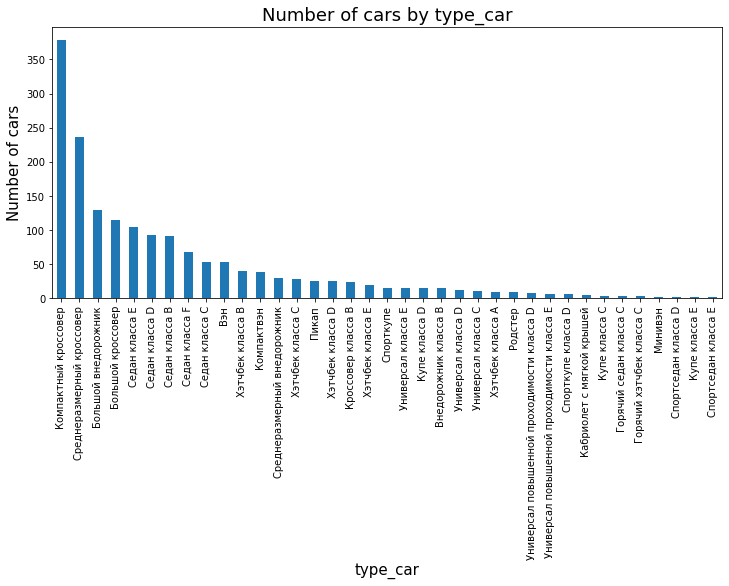

In [379]:
df['type_car'].value_counts().plot(kind='bar', figsize=(12,5))
plt.title('Number of cars by type_car', fontsize=18)
plt.ylabel('Number of cars',fontsize=15)
plt.xlabel('type_car',fontsize=15);

plt.show()

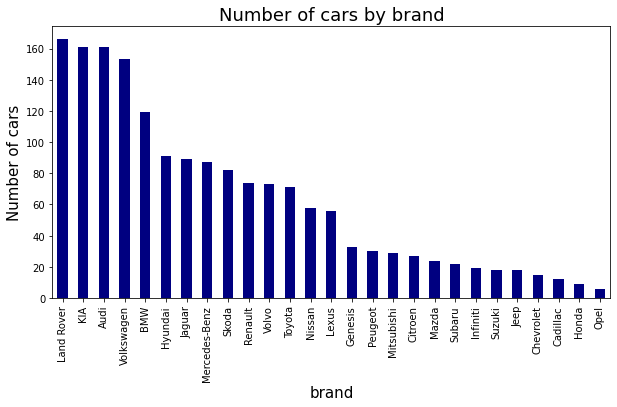

In [380]:
df['brand'].value_counts().plot(kind='bar', figsize=(10,5), color='navy')
plt.title('Number of cars by brand', fontsize=18)
plt.ylabel('Number of cars',fontsize=15)
plt.xlabel('brand',fontsize=15);

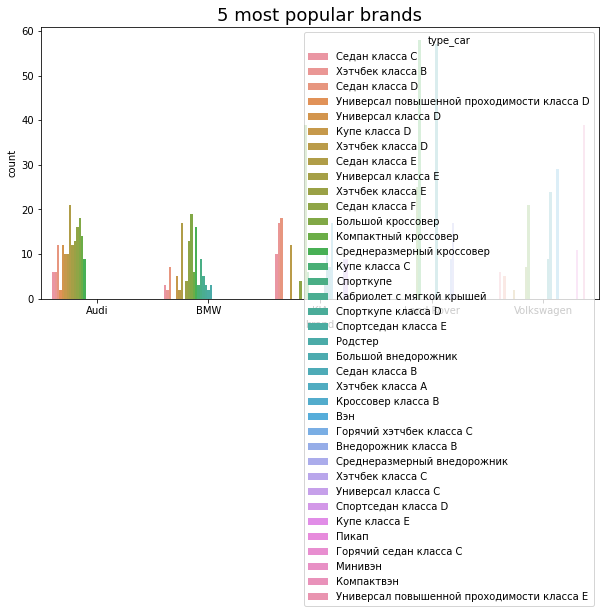

In [520]:
sns.countplot(x = df[df['brand'].\
                 isin(df['brand'].value_counts().head().index)]['brand'], hue='type_car',
             data=df);
plt.title('5 most popular brands', fontsize=18);

Как видно из графика выше, из-за большого количества типов кузово график становится трудно интерпретируемым

Построим таблицу, отражающую ту же информацию

In [447]:
from IPython.display import display_html
from itertools import chain, cycle
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ''
    for df, title in zip(args, chain(titles, cycle(['/br'])) ):
        html_str += '<th style ="text-align:center"<td style="vertical-align:top">>'
        html_str += f'<h2>{title}</h2>'
        html_str += df.to_html().replace('table', 'table style="display:inline"')
        html_str += '</td></th>'
    display_html(html_str, raw=True)

In [448]:
display_side_by_side(df[df['brand'].isin(['Land Rover', 'Audi', 'BMW'])].groupby(['brand', 'type_car']).agg({'brand':'count'}),
                    df[df['brand'].isin(['KIA', 'Volkswagen'])].groupby(['brand', 'type_car']).agg({'brand':'count'}))

> 
 
 
 
 
 brand 
 
 
 brand 
 type_car 
 
 
 
 
 
 Audi 
 Большой кроссовер 
 18 
 
 
 Компактный кроссовер 
 14 
 
 
 Купе класса D 
 10 
 
 
 Седан класса C 
 6 
 
 
 Седан класса D 
 12 
 
 
 Седан класса E 
 21 
 
 
 Седан класса F 
 16 
 
 
 Среднеразмерный кроссовер 
 9 
 
 
 Универсал класса D 
 12 
 
 
 Универсал класса E 
 12 
 
 
 Универсал повышенной проходимости класса D 
 2 
 
 
 Хэтчбек класса B 
 6 
 
 
 Хэтчбек класса D 
 10 
 
 
 Хэтчбек класса E 
 13 
 
 
 BMW 
 Большой кроссовер 
 19 
 
 
 Кабриолет с мягкой крышей 
 5 
 
 
 Компактный кроссовер 
 6 
 
 
 Купе класса C 
 3 
 
 
 Купе класса D 
 5 
 
 
 Родстер 
 3 
 
 
 Седан класса C 
 3 
 
 
 Седан класса D 
 7 
 
 
 Седан класса E 
 17 
 
 
 Седан класса F 
 13 
 
 
 Спорткупе 
 9 
 
 
 Спорткупе класса D 
 3 
 
 
 Спортседан класса E 
 2 
 
 
 Среднеразмерный кроссовер 
 16 
 
 
 Хэтчбек класса B 
 2 
 
 
 Хэтчбек класса D 
 2 
 
 
 Хэтчбек класса E 
 4 
 
 
 Land Rover 
 Большой внедорожник 
 57 
 
 
 Внедорожник класса B 
 9 
 
 
 Компактный кроссовер 
 25 
 
 
 Среднеразмерный внедорожник 
 17 
 
 
 Среднеразмерный кроссовер 
 58 
 
 
 > 
 
 
 
 
 brand 
 
 
 brand 
 type_car 
 
 
 
 
 
 KIA 
 Большой внедорожник 
 3 
 
 
 Компактный кроссовер 
 39 
 
 
 Кроссовер класса B 
 17 
 
 
 Седан класса B 
 10 
 
 
 Седан класса C 
 10 
 
 
 Седан класса D 
 18 
 
 
 Седан класса F 
 4 
 
 
 Среднеразмерный кроссовер 
 6 
 
 
 Универсал класса C 
 9 
 
 
 Хэтчбек класса A 
 7 
 
 
 Хэтчбек класса B 
 17 
 
 
 Хэтчбек класса C 
 9 
 
 
 Хэтчбек класса D 
 12 
 
 
 Volkswagen 
 Большой внедорожник 
 9 
 
 
 Большой кроссовер 
 7 
 
 
 Вэн 
 29 
 
 
 Компактвэн 
 39 
 
 
 Компактный кроссовер 
 21 
 
 
 Пикап 
 11 
 
 
 Седан класса B 
 24 
 
 
 Седан класса C 
 6 
 
 
 Седан класса D 
 5 
 
 
 Хэтчбек класса D 
 2

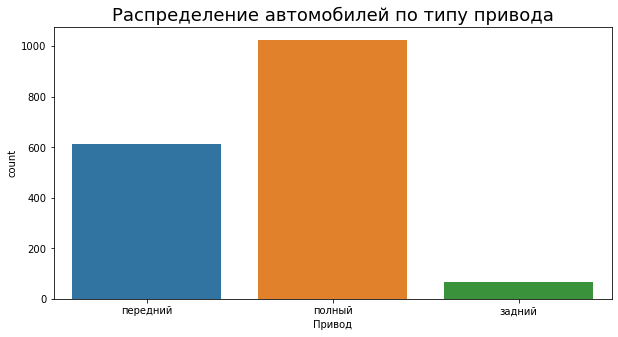

In [450]:
sns.countplot(df['Привод']);
plt.title('Распределение автомобилей по типу привода', fontsize=18);

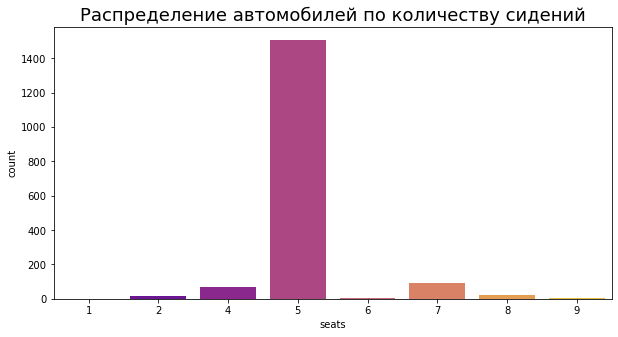

In [504]:
sns.countplot(df['seats'], palette=("plasma"));
plt.title('Распределение автомобилей по количеству сидений', fontsize=18);

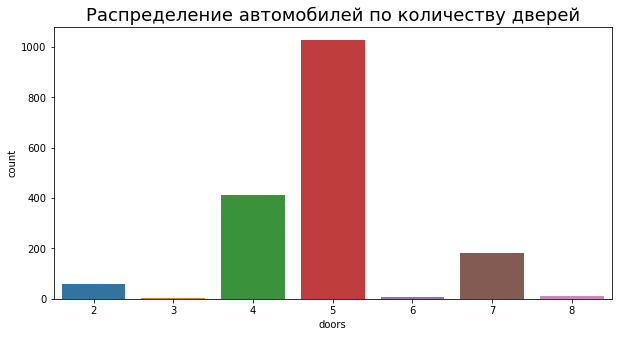

In [505]:
sns.countplot(df['doors']);
plt.title('Распределение автомобилей по количеству дверей', fontsize=18);

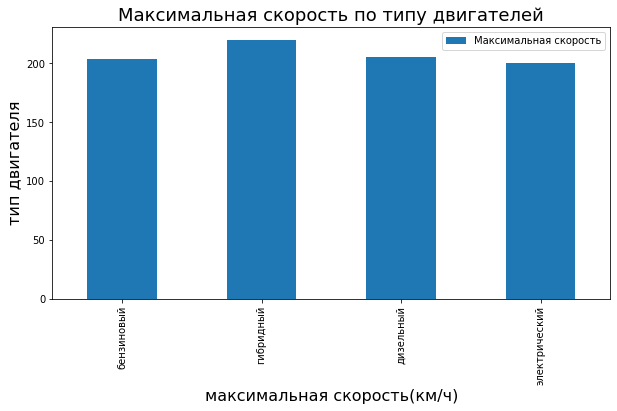

In [510]:
df.groupby('тип_двигателя').agg({'Максимальная скорость': 'median'}).plot(kind='bar');
plt.title('Максимальная скорость по типу двигателей', fontsize=18);
plt.ylabel('тип двигателя', fontsize=16);
plt.xlabel('максимальная скорость(км/ч)', fontsize=16);

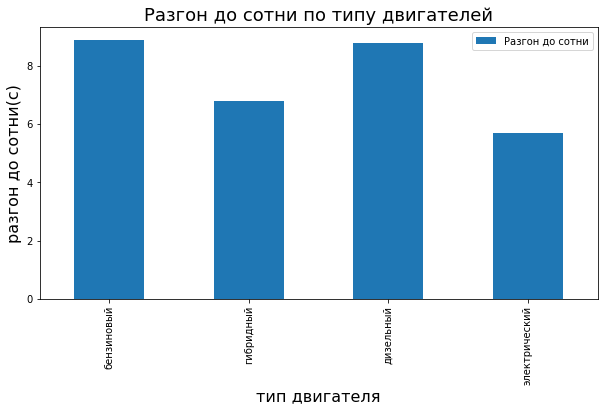

In [514]:
df.groupby('тип_двигателя').agg({'Разгон до сотни': 'median'}).plot(kind='bar');
plt.title('Разгон до сотни по типу двигателей', fontsize=18);
plt.ylabel('разгон до сотни(с)', fontsize=16);
plt.xlabel('тип двигателя', fontsize=16);

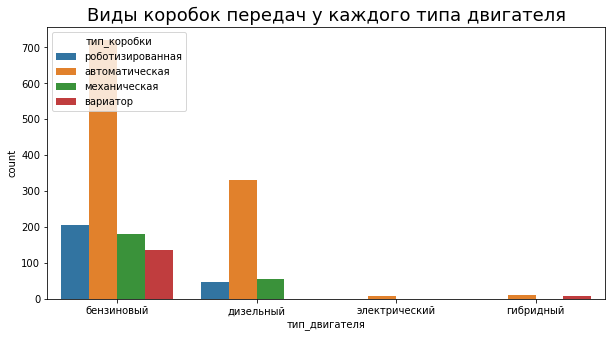

In [524]:
sns.countplot(x='тип_двигателя', hue='тип_коробки', data=df);
plt.title('Виды коробок передач у каждого типа двигателя', fontsize=18);

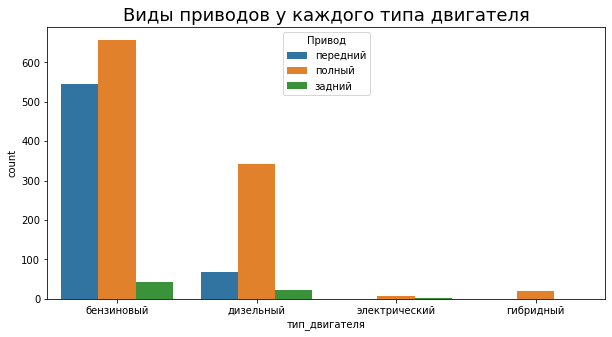

In [525]:
sns.countplot(x='тип_двигателя', hue='Привод', data=df);
plt.title('Виды приводов у каждого типа двигателя', fontsize=18);

## Количественные

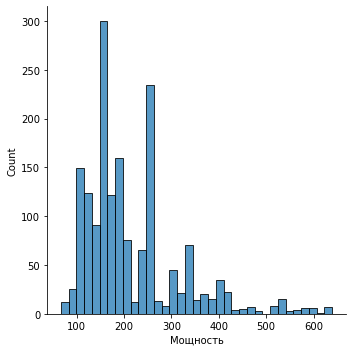

In [388]:
sns.displot(df['Мощность']);

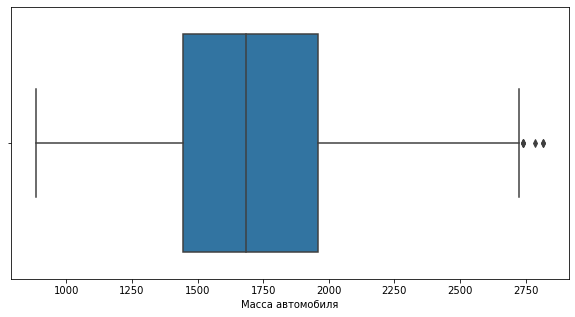

In [389]:
sns.boxplot(df['Масса автомобиля']);

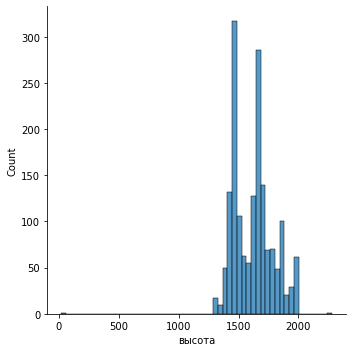

In [521]:
sns.displot(df['высота']);

## Корреляции между признаками

<AxesSubplot:>

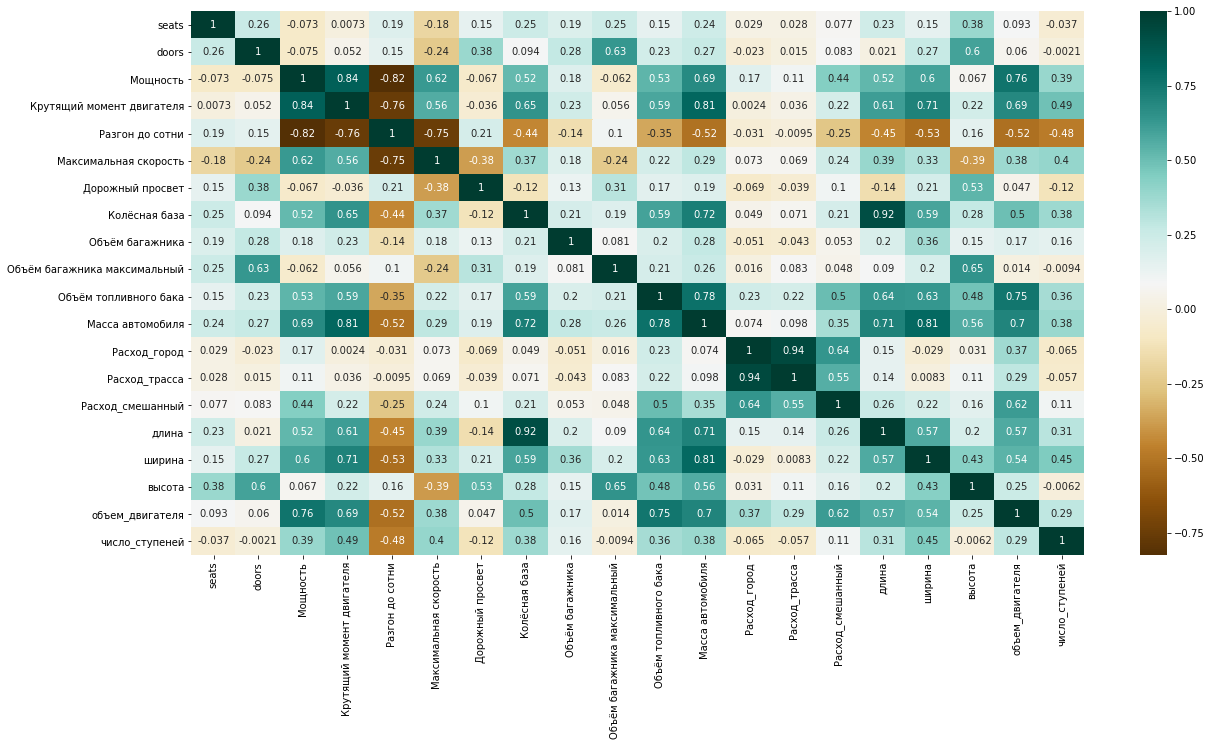

In [390]:
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

Target looks like classification
Linear Discriminant Analysis training set score: 0.823


[[<Figure size 1440x5328 with 20 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1152x288 with 4 Axes>],
 None]

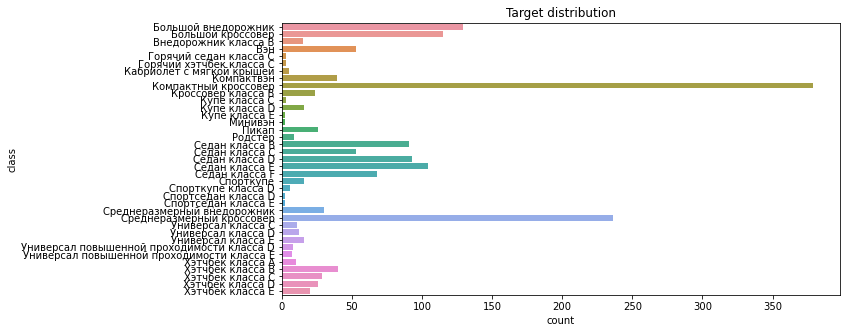

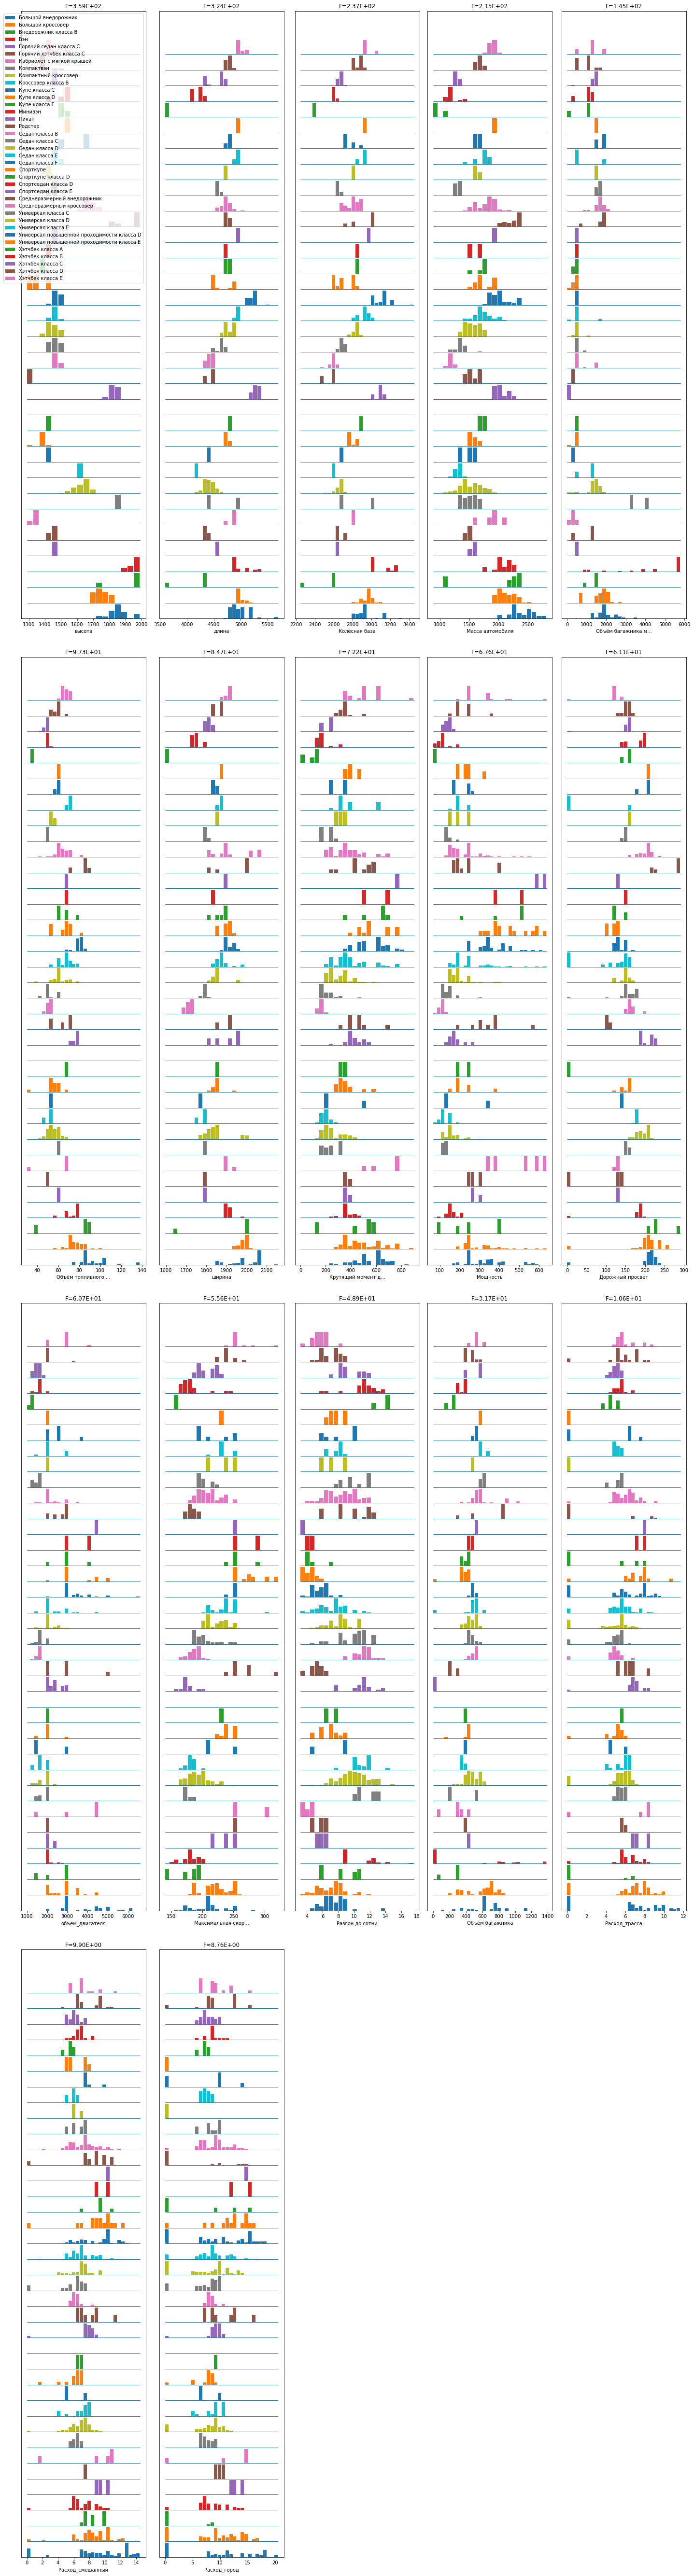

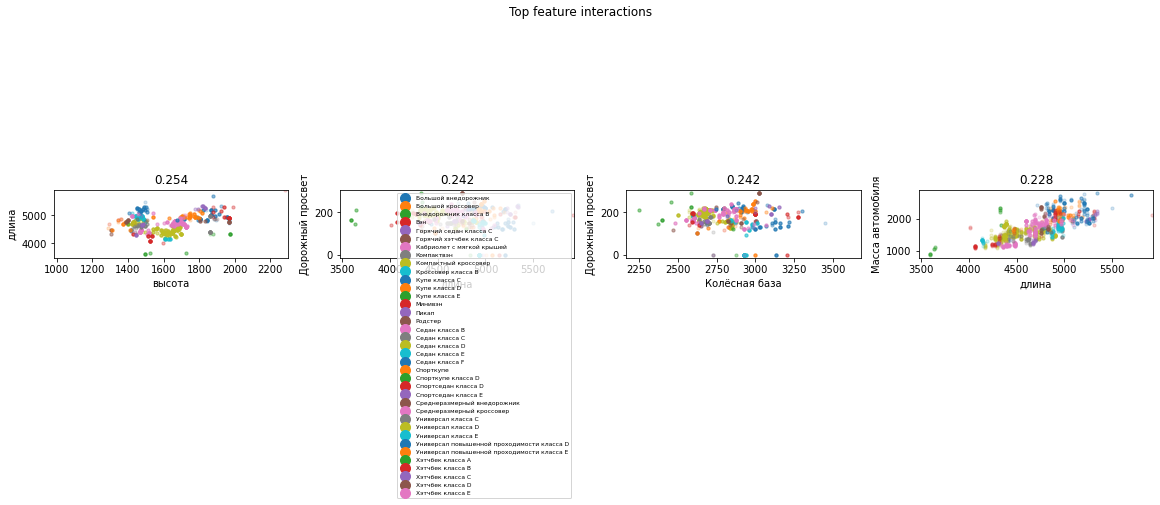

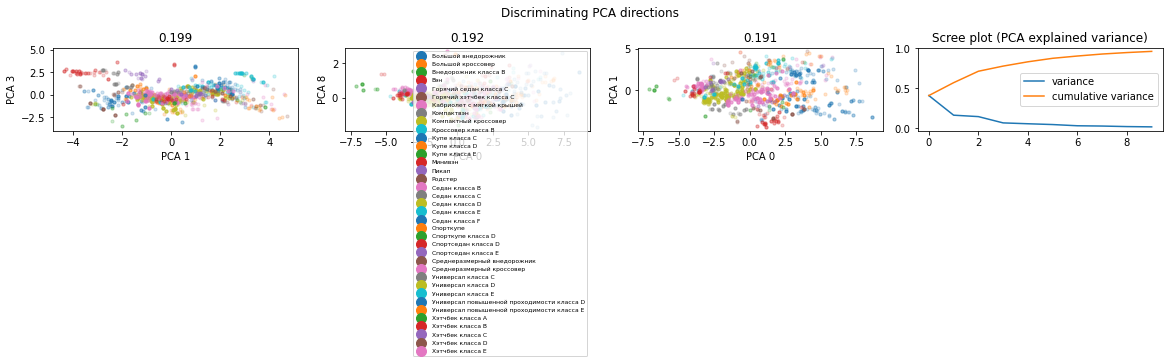

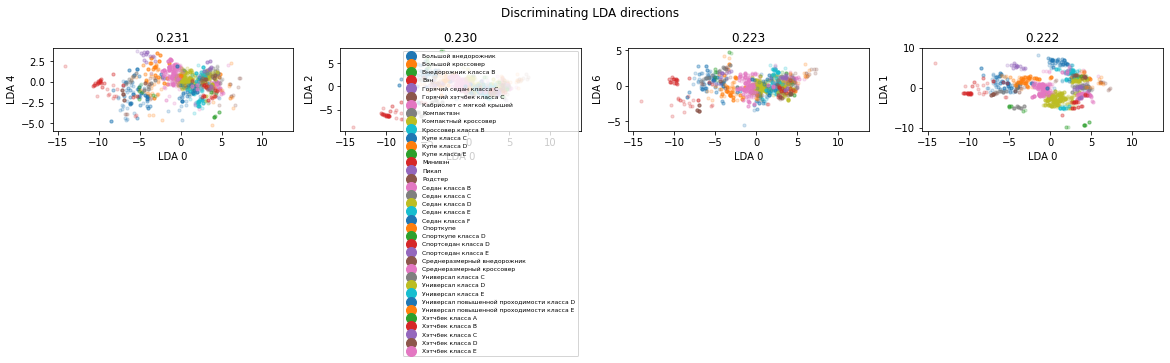

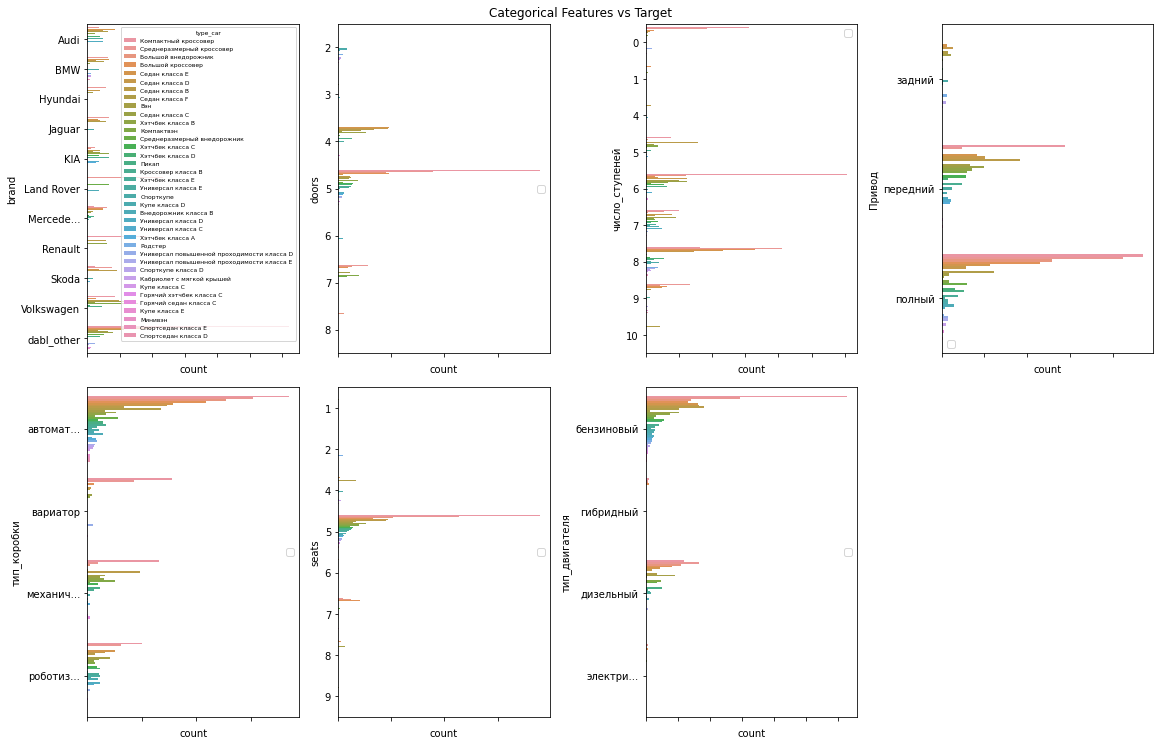

In [391]:
dabl.plot(df, 'type_car') # Данная команда дает максимально подробное описание данных в датафрэйме

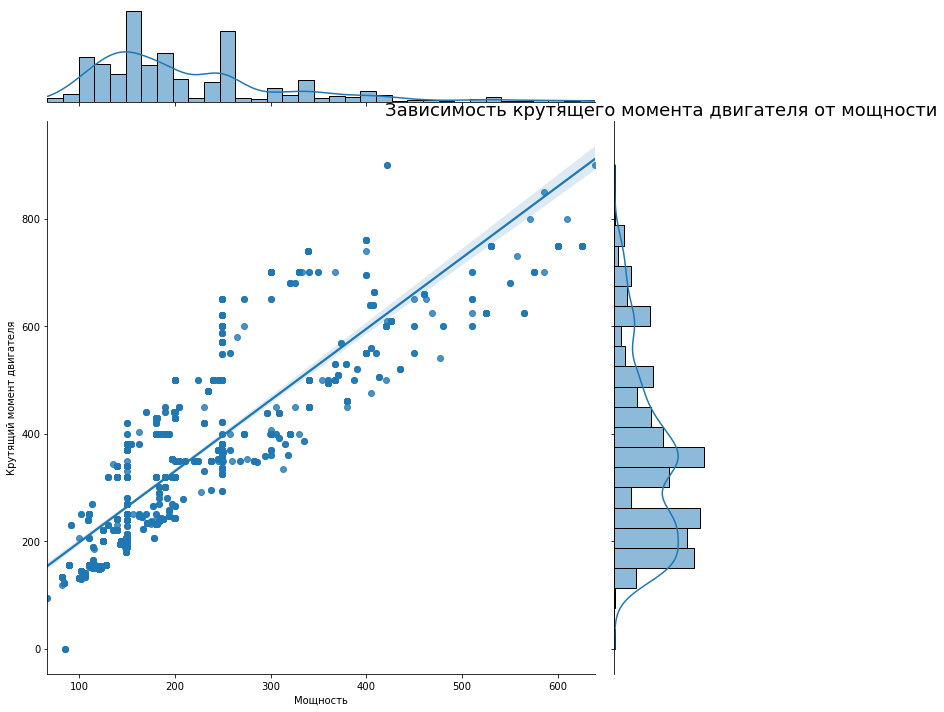

In [519]:
sns.jointplot(x='Мощность', y='Крутящий момент двигателя', data=df, kind='reg', height=10);
plt.title('Зависимость крутящего момента двигателя от мощности', fontsize=18);

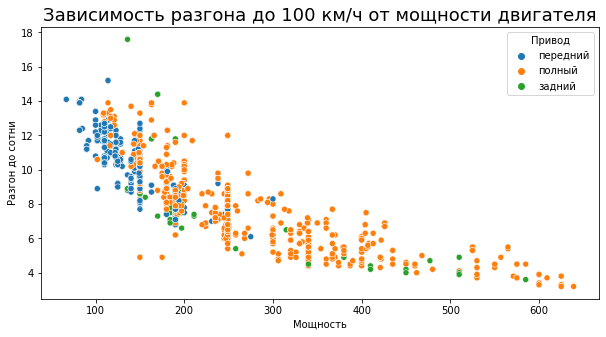

In [398]:
sns.scatterplot(x=df['Мощность'],y=df['Разгон до сотни'],hue=df['Привод'])
plt.title('Зависимость разгона до 100 км/ч от мощности двигателя', fontsize=18);

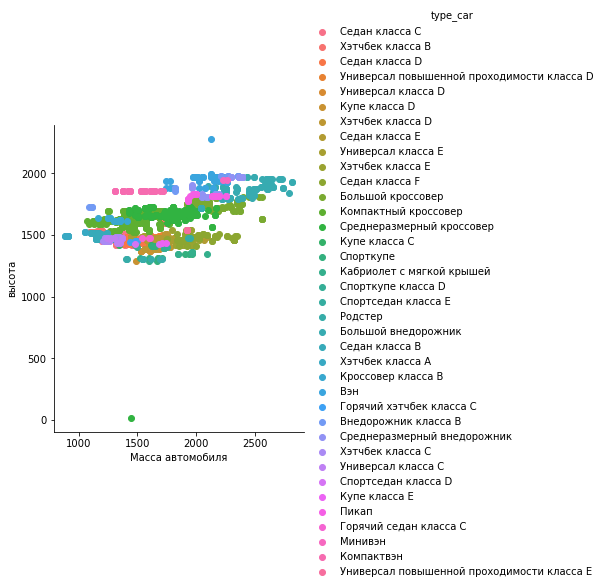

In [530]:
sns.FacetGrid(df, hue="type_car", size=5) \
   .map(plt.scatter, "Масса автомобиля", "высота") \
   .add_legend();
# Распределение типов кузовов в зависимости от массы и высоты автомобиля

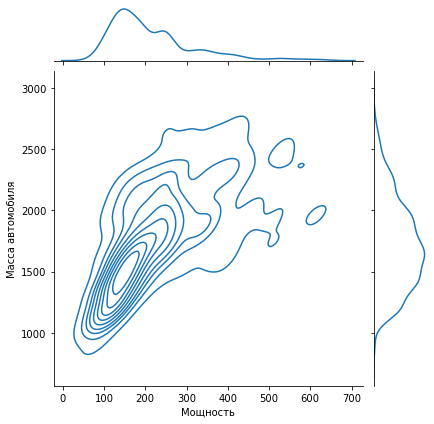

In [451]:
sns.jointplot(x="Мощность", y="Масса автомобиля", data=df, kind="kde");

# Классификация
## Подготовка данных к модели

In [531]:
df.head()

,brand,model,complect,type_car,seats,doors,Мощность,Крутящий момент двигателя,Привод,Разгон до сотни,...,Расход_город,Расход_трасса,Расход_смешанный,длина,ширина,высота,тип_двигателя,объем_двигателя,тип_коробки,число_ступеней
0,Audi,A3 Sedan,1.4 TFSI 7AMT,Седан класса C,5,4,150,250,передний,8.2,...,5.9,4.1,4.8,4458,1796,1416,бензиновый,1395,роботизированная,7
1,Audi,A3 Sedan,sport 1.4 TFSI 7AMT,Седан класса C,5,4,150,250,передний,8.2,...,5.9,4.1,4.8,4458,1796,1416,бензиновый,1395,роботизированная,7
2,Audi,A3 Sedan,2.0 TFSI 7AMT,Седан класса C,5,4,190,320,передний,6.8,...,7.2,4.7,5.6,4458,1796,1416,бензиновый,1984,роботизированная,7
3,Audi,A3 Sedan,2.0 TFSI 7AMT quattro,Седан класса C,5,4,190,320,полный,6.2,...,7.2,4.8,5.7,4458,1796,1416,бензиновый,1984,роботизированная,7
4,Audi,A3 Sedan,sport 2.0 TFSI 7AMT,Седан класса C,5,4,190,320,передний,6.8,...,7.2,4.7,5.6,4458,1796,1416,бензиновый,1984,роботизированная,7


In [405]:
df_ml = df.drop(['brand', 'model'], axis=1) # Избавимся от данных названий моделей и комплектаций

Далее преобразуем категориальные признаки используя pd.get_dummies()

In [407]:
def dummies(x,df):
    temp = pd.get_dummies(df[x])
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

In [408]:
df_ml = dummies('Привод', df_ml)

In [409]:
df_ml = dummies('тип_двигателя', df_ml)
df_ml = dummies('тип_коробки', df_ml)

## Классификация моделей по типу кузова (без подклассов, колонка type_car): - Седан - Хетчбек - Кроссовер - Внедорожник.
### Поэтому преобразуем типы кузовов, остальные типы использовать не будем

In [410]:
df_ml['type_car'].nunique()

37

In [411]:
df_ml['type_car'].value_counts()

Компактный кроссовер                          379
Среднеразмерный кроссовер                     236
Большой внедорожник                           129
Большой кроссовер                             115
Седан класса E                                104
Седан класса D                                 93
Седан класса B                                 91
Седан класса F                                 68
Седан класса C                                 53
Вэн                                            53
Хэтчбек класса B                               40
Компактвэн                                     39
Среднеразмерный внедорожник                    30
Хэтчбек класса C                               29
Пикап                                          26
Хэтчбек класса D                               26
Кроссовер класса B                             24
Хэтчбек класса E                               20
Спорткупе                                      16
Универсал класса E                             16


In [412]:
df_ml['type_car'] = df_ml['type_car'].str.lower() # приведем названия типов кузовов к нижнему регистру

In [413]:
target_map = {
    'компактный кроссовер': 'кроссовер',
    'среднеразмерный кроссовер': 'кроссовер',
    'большой внедорожник': 'внедорожник',
    'большой кроссовер': 'кроссовер',
    'седан класса e': 'седан',
    'седан класса d': 'седан',
    'седан класса b': 'седан',
    'седан класса f': 'седан',
    'седан класса c': 'седан',
    'вэн': np.NaN,
    'хэтчбек класса b': 'хэтчбек',
    'компактвэн': np.NaN,
    'среднеразмерный внедорожник': 'внедорожник',
    'хэтчбек класса c': 'хэтчбек',
    'хэтчбек класса d': 'хэтчбек',
    'пикап': np.NaN,
    'кроссовер класса b': 'кроссовер',
    'хэтчбек класса e': 'хэтчбек',
    'универсал класса e': np.NaN,
    'спорткупе': np.NaN,
    'купе класса d': np.NaN,
    'внедорожник класса b': 'внедорожник',
    'универсал класса d': np.NaN,
    'универсал класса c': np.NaN,
    'хэтчбек класса a': 'хэтчбек',
    'родстер': np.NaN,
    'универсал повышенной проходимости класса d': np.NaN,
    'универсал повышенной проходимости класса e': np.NaN,
    'спорткупе класса d': np.NaN,
    'кабриолет с мягкой крышей': np.NaN,
    'горячий седан класса c': 'седан',
    'купе класса c': np.NaN,
    'горячий хэтчбек класса c': 'хэтчбек',
    'спортседан класса e': 'седан',
    'спортседан класса d': 'седан',
    'купе класса e': np.NaN,
    'минивэн': np.NaN
}

In [414]:
df_ml['target'] = df_ml['type_car'].map(target_map) # Непосредственно преобразование типов кузовов

In [415]:
df_ml = df_ml.dropna() # Избавимся от остальных типов кузовов
df_ml.drop(['type_car'],axis=1, inplace=True)

In [416]:
df_ml.shape

(1472, 33)

In [417]:
df_ml['target'].unique() # седан-хэтчбек-кроссовер-внедорожник

array(['седан', 'хэтчбек', 'кроссовер', 'внедорожник'], dtype=object)

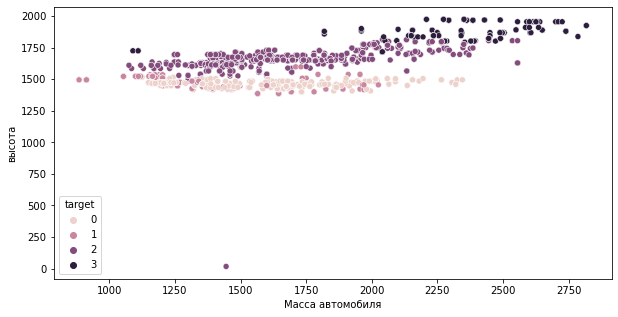

In [485]:
sns.scatterplot(x=df_ml['Масса автомобиля'], y=df_ml['высота'], hue=df_ml['target'], cmap='cool');

In [419]:
df_ml.head()

,complect,seats,doors,Мощность,Крутящий момент двигателя,Разгон до сотни,Максимальная скорость,Дорожный просвет,Колёсная база,Объём багажника,...,полный,бензиновый,гибридный,дизельный,электрический,автоматическая,вариатор,механическая,роботизированная,target
0,1.4 TFSI 7AMT,5,4,150,250,8.2,224,165,2637,425,...,0,1,0,0,0,0,0,0,1,седан
1,sport 1.4 TFSI 7AMT,5,4,150,250,8.2,224,165,2637,425,...,0,1,0,0,0,0,0,0,1,седан
2,2.0 TFSI 7AMT,5,4,190,320,6.8,250,165,2637,425,...,0,1,0,0,0,0,0,0,1,седан
3,2.0 TFSI 7AMT quattro,5,4,190,320,6.2,242,165,2637,390,...,1,1,0,0,0,0,0,0,1,седан
4,sport 2.0 TFSI 7AMT,5,4,190,320,6.8,242,165,2637,425,...,0,1,0,0,0,0,0,0,1,седан


In [420]:
target_label = {
    'седан': 0,
    'хэтчбек': 1,
    'кроссовер': 2,
    'внедорожник': 3
}

In [421]:
df_ml['target'] = df_ml['target'].map(target_label) # Преобразуем target в числовые классы

In [422]:
X = df_ml.drop(['target', 'complect'], axis=1) # Выделим признаки и классы
y = df_ml.target

In [423]:
X_vis = df_ml.drop(['target', 'complect'], axis=1) # Для визуализации feature_importances

### Так как признаки лежат в разных масштабах, нужно их стандартизировать

In [424]:
from sklearn.preprocessing import StandardScaler

In [425]:
scaler = StandardScaler()

In [426]:
X = scaler.fit_transform(X)

In [427]:
from sklearn.model_selection import train_test_split

In [467]:
# Выделим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

# Выбор модели для обучения

In [468]:
models = [
    # GLM
    LogisticRegression(random_state=1),
    # Nearest Neighbor
    KNeighborsClassifier(),
    # SVM
    SVC(probability=True, random_state=1),
    # Trees
    DecisionTreeClassifier(random_state=1),
    # Ensemble
    RandomForestClassifier(random_state=1),

    AdaBoostClassifier(random_state=1),
    
    XGBClassifier(random_state=1)
]

In [469]:
# K-FOld Cross validation
cv_split = ShuffleSplit(n_splits=10,
                        test_size=.3,
                        train_size=.7,
                        random_state=1)

In [470]:
cv_split = ShuffleSplit(n_splits=10,
                        test_size=.3,
                        train_size=.7,
                        random_state=1)

# Создадим отдельный датафрэйм "compare" для сравнения результатов моделей

columns = ['Name',
           'Parameters',
           'TrainAccuracyMean',
           'TestAccuracyMean',
           'AvgTrainingTime'
           ]

compare = pd.DataFrame(columns=columns)

## Обучение моделей

In [471]:
for row_index, model in enumerate(models):

    model_name = model.__class__.__name__

    print(f"Training started for {model_name}")
    
    # model cross validation results
    cv_results = cross_validate(model,
                                X_train,
                                y_train,
                                cv=cv_split,
                                scoring='accuracy',
                                return_train_score=True,
                                n_jobs=-1)
    
    # Add cv results to comparision dataframe
    compare.loc[row_index, 'Name'] = model_name
    
    compare.loc[row_index,
                'Parameters'] = str(model.get_params())
    
    compare.loc[row_index, 
                'TrainAccuracyMean'] = cv_results['train_score'].mean()
    
    compare.loc[row_index,
                'TestAccuracyMean'] = cv_results['test_score'].mean()
    
    compare.loc[row_index,
                'AvgTrainingTime'] = cv_results['fit_time'].mean()

    print(f"Training completed!!\n")
    
    compare.sort_values(by=['TestAccuracyMean'],
                        ascending=False,
                        inplace=True)

Training started for LogisticRegression
Training completed!!

Training started for KNeighborsClassifier
Training completed!!

Training started for SVC
Training completed!!

Training started for DecisionTreeClassifier
Training completed!!

Training started for RandomForestClassifier
Training completed!!

Training started for AdaBoostClassifier
Training completed!!

Training started for XGBClassifier
Training completed!!



In [472]:
compare

,Name,Parameters,TrainAccuracyMean,TestAccuracyMean,AvgTrainingTime
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.991525,0.223539
6,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",1.0,0.989831,1.931949
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.984746,0.004491
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.98226,0.966667,0.083908
2,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.981774,0.959322,0.144665
1,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.946294,0.901412,0.002669
5,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.864156,0.867232,0.139186


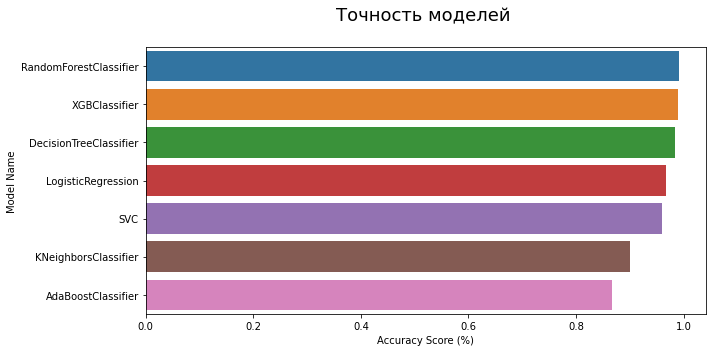

In [533]:
plt.figure(figsize=(10, 5))
sns.barplot(x='TestAccuracyMean', y='Name', data=compare)
plt.title('Точность моделей \n', fontsize=18)
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Model Name')
plt.tight_layout()

## Выбор модели
### Видно, что наиболее успешно справилась модель случайный лес (Random Forest)

In [494]:
classifier = RandomForestClassifier(random_state=1)

In [495]:
# Подберем параметры
params = {
    'max_depth': [25, 26, 27],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [25, 30]
}

In [496]:
# Обучим модель с помощью GridSearchCV
grid_forest = GridSearchCV(
    classifier, param_grid=params, cv=3, n_jobs=-1, return_train_score=True
)

In [497]:
%%time # Обучение модели
grid_forest.fit(X_train, y_train)

Wall time: 454 ms


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [25, 26, 27],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [25, 30]},
             return_train_score=True)

### Выделим лучшие параметры для модели

In [498]:
best_model = grid_forest.best_estimator_
best_params = grid_forest.best_params_
best_score = grid_forest.best_score_

print(f"\nTuned Random Forest Parameters:\n{best_params}")
print(f"\nBest score: {best_score}")


Tuned Random Forest Parameters:
{'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 30}

Best score: 0.994049782762978


In [499]:
prediction = best_model.predict(X_test)

In [500]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Результаты модели, метрики качества

In [501]:
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))
print(accuracy_score(y_test, prediction))

[[ 78   0   0   0]
 [  0  26   0   0]
 [  0   0 164   0]
 [  0   0   0  27]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00       164
           3       1.00      1.00      1.00        27

    accuracy                           1.00       295
   macro avg       1.00      1.00      1.00       295
weighted avg       1.00      1.00      1.00       295

1.0


## Feature importances

In [502]:
feature_importances = best_model.feature_importances_

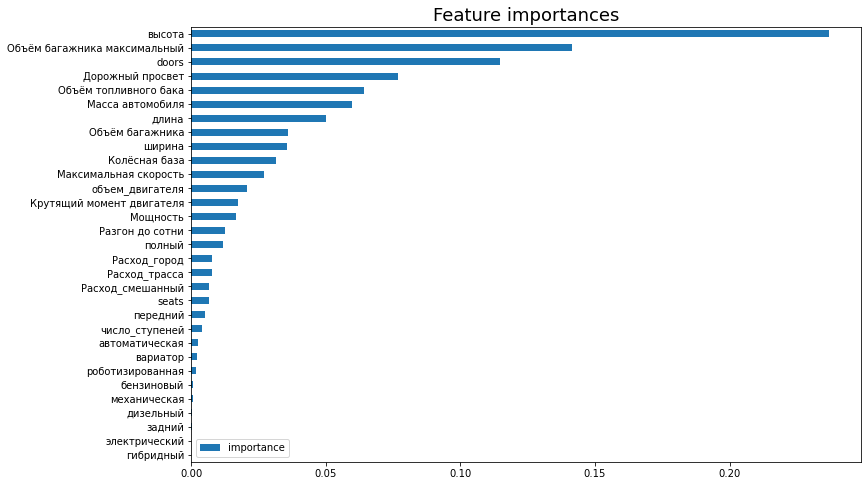

In [503]:
imp = pd.DataFrame(feature_importances, index=X_vis.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));
plt.title('Feature importances', fontsize=18);